In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
BATCH_SIZE = 16
EPOCHS = 200
IMAGE_SIZE = (128, 128)  # Resize images to 128x128
OUTPUT_DIR = "/content/drive/MyDrive/Copy of chest_xray/denoising_results"
BASE_DIR = "/content/drive/MyDrive/Copy of chest_xray"
CATEGORIES = ['BACTERIA', 'NORMAL', 'VIRUS']
NOISE_TYPES = ['noisy_gaussian', 'noisy_impulse', 'noisy_poisson', 'noisy_salt_pepper', 'noisy_speckle']

# Create output directory
def create_output_directory(output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

# Load and preprocess images
def load_and_resize_images(image_dir, target_size=(128, 128), color_mode="grayscale"):
    image_list = []
    if not os.path.exists(image_dir):
        print(f"Error: Directory {image_dir} does not exist!")
        return np.array([])

    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = load_img(os.path.join(image_dir, filename), target_size=target_size, color_mode=color_mode)
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] range
            if img_array.ndim == 3 and img_array.shape[-1] == 3:
                img_array = np.mean(img_array, axis=-1, keepdims=True)  # Convert RGB to grayscale
            image_list.append(img_array)

    images = np.array(image_list)
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)
    return images

# Define U-Net model
def unet_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(p4)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u4 = layers.UpSampling2D((2, 2))(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Train U-Net model
def train_model():
    train_images, train_noisy_images = [], []
    for category in CATEGORIES:
        train_images.extend(load_and_resize_images(os.path.join(BASE_DIR, 'processed_train', category), IMAGE_SIZE))
        for noise in NOISE_TYPES:
            train_noisy_images.extend(load_and_resize_images(
                os.path.join(BASE_DIR, 'processed_train_noisy', f"{category}_{noise}"), IMAGE_SIZE))

    train_images = np.array(train_images)
    train_noisy_images = np.array(train_noisy_images)

    assert train_images.shape[0] == train_noisy_images.shape[0], "Mismatch in training images and noisy images"

    model = unet_model(input_shape=(128, 128, 1))
    model.fit(train_noisy_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)
    model.save_weights(os.path.join(OUTPUT_DIR, "unet_weights.h5"))
    return model

# Compute metrics
def compute_metrics(original, denoised):
    original = original.squeeze()
    denoised = denoised.squeeze()
    psnr_value = psnr(original, denoised, data_range=1.0)
    ssim_value = ssim(original, denoised, data_range=1.0)
    mse_value = np.mean((original - denoised) ** 2)
    return psnr_value, ssim_value, mse_value

# Visualize and save results
def visualize_and_save_results(model):
    metrics_data = []
    for category in CATEGORIES:
        for noise in NOISE_TYPES:
            original_images = load_and_resize_images(os.path.join(BASE_DIR, 'processed_train', category), IMAGE_SIZE)
            noisy_images = load_and_resize_images(os.path.join(BASE_DIR, 'processed_train_noisy', f"{category}_{noise}"), IMAGE_SIZE)

            original_image = original_images[0]
            noisy_image = noisy_images[0]
            denoised_image = model.predict(np.expand_dims(noisy_image, axis=0))[0]

            psnr_value, ssim_value, mse_value = compute_metrics(original_image, denoised_image)

            metrics_data.append({
                "Category": category,
                "Noise Type": noise,
                "PSNR": psnr_value,
                "SSIM": ssim_value,
                "MSE": mse_value
            })

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(original_image.squeeze(), cmap='gray')
            axes[0].set_title("Original")
            axes[1].imshow(noisy_image.squeeze(), cmap='gray')
            axes[1].set_title("Noisy")
            axes[2].imshow(denoised_image.squeeze(), cmap='gray')
            axes[2].set_title("Denoised")
            plt.savefig(os.path.join(OUTPUT_DIR, f"{category}_{noise}_denoising.png"))
            plt.close(fig)

    pd.DataFrame(metrics_data).to_excel(os.path.join(OUTPUT_DIR, "denoising_metrics.xlsx"), index=False)

# Main function
def main():
    create_output_directory(OUTPUT_DIR)
    model = train_model()
    visualize_and_save_results(model)

if __name__ == "__main__":
    main()


In [ ]:
from tensorflow.keras import layers, models


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd

# Paths
BASE_DIR = "/content/drive/MyDrive/CS415Project/chest_xray"
OUTPUT_DIR = os.path.join(BASE_DIR, "denoising_results")
MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_DIR, "unet_weights.h5")
TEST_DIR = os.path.join(BASE_DIR, "processed_test")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# U-Net model definition
def unet_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(p4)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u4 = layers.UpSampling2D((2, 2))(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Load and preprocess test images
def load_and_resize_images(image_dir, target_size=(128, 128), color_mode="grayscale"):
    image_list = []
    file_names = []
    if not os.path.exists(image_dir):
        print(f"Error: Directory {image_dir} does not exist!")
        return np.array([]), []

    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = load_img(os.path.join(image_dir, filename), target_size=target_size, color_mode=color_mode)
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] range
            if img_array.ndim == 3 and img_array.shape[-1] == 3:
                img_array = np.mean(img_array, axis=-1, keepdims=True)  # Convert RGB to grayscale
            image_list.append(img_array)
            file_names.append(filename)

    images = np.array(image_list)
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)
    return images, file_names

# Compute PSNR and SSIM metrics
def compute_metrics(original, denoised):
    original = original.squeeze()
    denoised = denoised.squeeze()
    psnr_value = psnr(original, denoised, data_range=1.0)
    ssim_value = ssim(original, denoised, data_range=1.0)
    return psnr_value, ssim_value

# Apply the model to test images and save results
def test_model(model, test_dir, output_dir):
    categories = os.listdir(test_dir)
    metrics_data = []

    for category in categories:
        category_dir = os.path.join(test_dir, category)
        images, file_names = load_and_resize_images(category_dir)
        if len(images) == 0:
            continue

        for i, img in enumerate(images):
            # Predict denoised image
            denoised_img = model.predict(np.expand_dims(img, axis=0))[0]

            # Compute metrics
            psnr_value, ssim_value = compute_metrics(img, denoised_img)
            metrics_data.append({"Category": category, "File": file_names[i], "PSNR": psnr_value, "SSIM": ssim_value})

            # Save original, noisy, and denoised images
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            axes[0].imshow(img.squeeze(), cmap='gray')
            axes[0].set_title("Original")
            axes[1].imshow(denoised_img.squeeze(), cmap='gray')
            axes[1].set_title("Denoised")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{category}_{file_names[i]}_denoised.png"))
            plt.close(fig)

    # Save metrics to Excel
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_excel(os.path.join(output_dir, "test_metrics.xlsx"), index=False)

# Main function
def main():
    # Load trained model
    model = unet_model(input_shape=(128, 128, 1))
    model.load_weights(MODEL_WEIGHTS_PATH)

    # Test model on the test set
    test_model(model, TEST_DIR, OUTPUT_DIR)

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
Category: BACTERIA, Noise Type: BACTERIA_noisy_gaussian
PSNR: 16.21, SSIM: 0.3628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Category: BACTERIA, Noise Type: BACTERIA_noisy_salt_pepper
PSNR: 19.17, SSIM: 0.4929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Category: BACTERIA, Noise Type: BACTERIA_noisy_poisson
PSNR: 16.96, SSIM: 0.3287
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Category: BACTERIA, Noise Type: BACTERIA_noisy_impulse
PSNR: 20.12, SSIM: 0.5221
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
Category: BACTERIA, Noise Type: BACTERIA_noisy_speckle
PSNR: 15.62, SSIM: 0.3678
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
Category: BACTERIA, Noise Type: VIRUS_noisy_gaussian
PSNR: 12.69, SSIM: 0.3123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Category: BACTERIA, Noise Type: VIRUS_noisy_salt_pepper
PSNR: 15.65, SSIM: 0.2880
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Category: BACTERIA, Noise Type: VIRUS_noisy_poisson
PSNR: 18.32, SSIM: 0.5030
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/.shortcut-targets-by-id/10okZBLr0FJTMk3nwGqQ8Q2O08u4ovfxT/chest_xray/denoising_results_test/BACTERIA_noisy_gaussian_image_1.png'

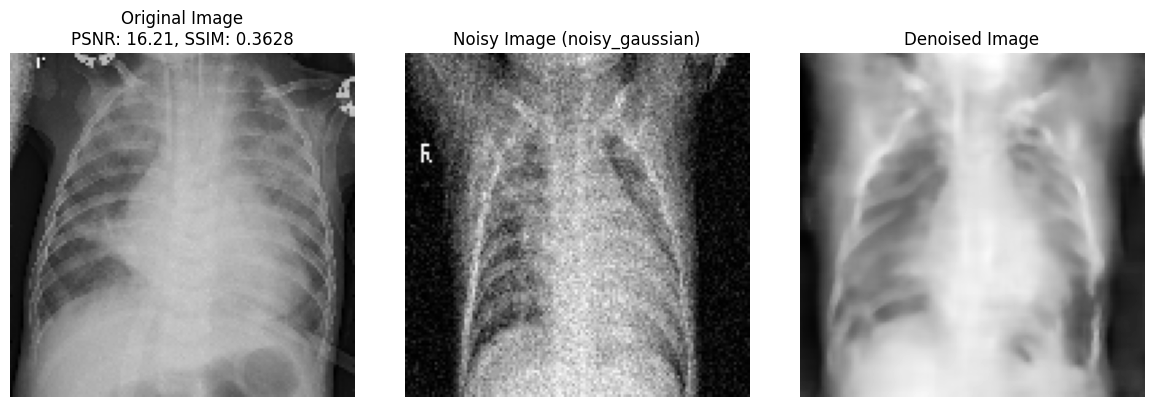

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Paths
BASE_DIR = "/content/drive/MyDrive/CS415Project/chest_xray"
OUTPUT_DIR = os.path.join(BASE_DIR, "denoising_results_test")
OUTPUT_DIR_model = os.path.join(BASE_DIR, "denoising_results")

MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_DIR_model, "unet_weights.h5")
TEST_DIR = os.path.join(BASE_DIR, "processed_test")
NOISY_TEST_DIR = os.path.join(BASE_DIR, "processed_test_noisy")

# U-Net model definition
def unet_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(p4)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u4 = layers.UpSampling2D((2, 2))(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Load the trained model weights
def load_trained_model(model_weights_path):
    model = unet_model(input_shape=(128, 128, 1))
    model.load_weights(model_weights_path)
    return model

# Load and preprocess the images
def load_and_resize_images(image_dir, target_size=(128, 128), color_mode="grayscale"):
    image_list = []
    if not os.path.exists(image_dir):
        print(f"Error: Directory {image_dir} does not exist!")
        return np.array([])

    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = load_img(os.path.join(image_dir, filename), target_size=target_size, color_mode=color_mode)
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] range
            if img_array.ndim == 3 and img_array.shape[-1] == 3:
                img_array = np.mean(img_array, axis=-1, keepdims=True)  # Convert RGB to grayscale
            image_list.append(img_array)

    images = np.array(image_list)
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)
    return images

# Calculate PSNR and SSIM for the first image of each noisy folder and compute their averages
def calculate_metrics(model, test_dir, noisy_test_dir, output_dir, num_images=1):
    categories = os.listdir(test_dir)
    noisy_categories = os.listdir(noisy_test_dir)

    total_psnr = 0
    total_ssim = 0
    count = 0

    for category in categories:
        original_images = load_and_resize_images(os.path.join(test_dir, category), target_size=(128, 128))

        for noisy_category in noisy_categories:
            noisy_images = load_and_resize_images(os.path.join(noisy_test_dir, noisy_category), target_size=(128, 128))

            # Get the first noisy image
            noisy_image = noisy_images[0]  # Adjust index if you want to pick a different noisy image

            # Corresponding original image
            original_image = original_images[count % len(original_images)]  # Ensuring circular access

            # Denoise image using model
            denoised_image = model.predict(np.expand_dims(noisy_image, axis=0))[0]

            # Calculate PSNR and SSIM
            psnr_value = psnr(original_image.squeeze(), denoised_image.squeeze(), data_range=1.0)
            ssim_value = ssim(original_image.squeeze(), denoised_image.squeeze(), data_range=1.0)

            total_psnr += psnr_value
            total_ssim += ssim_value
            count += 1

            # Print metrics for each image processed
            print(f"Category: {category}, Noise Type: {noisy_category}")
            print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count

    # Print average PSNR and SSIM values
    print(f"\nAverage PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim

# Visualize and compare original, noisy, and denoised images
def compare_images(model, test_dir, noisy_test_dir, output_dir, num_images=30):
    categories = os.listdir(test_dir)
    noisy_types = ['noisy_gaussian', 'noisy_impulse', 'noisy_poisson', 'noisy_salt_pepper', 'noisy_speckle']

    for category in categories:
        # Load original and noisy images
        original_images = load_and_resize_images(os.path.join(test_dir, category), target_size=(128, 128))

        # Ensure that noisy images are loaded in sequence for each noise type
        for i, noise_type in enumerate(noisy_types):
            noisy_images = load_and_resize_images(os.path.join(noisy_test_dir, f"{category}_{noise_type}"), target_size=(128, 128))

            # Pair the original images with noisy images based on your pattern
            for j in range(0, num_images, 30):  # Adjusts for images 1, 30, 60, 90, 120
                if j + i < len(original_images):
                    original_image = original_images[j + i]  # Image from original folder
                    noisy_image = noisy_images[0]  # The first noisy image corresponding to this noise type

                    # Denoise the image using the model
                    denoised_image = model.predict(np.expand_dims(noisy_image, axis=0))[0]

                    # Calculate PSNR and SSIM
                    psnr_value = psnr(original_image.squeeze(), denoised_image.squeeze(), data_range=1.0)
                    ssim_value = ssim(original_image.squeeze(), denoised_image.squeeze(), data_range=1.0)

                    # Create a figure to display the original, noisy, and denoised images
                    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                    axes[0].imshow(original_image.squeeze(), cmap='gray')
                    axes[0].set_title(f"Original Image\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")
                    axes[0].axis('off')

                    axes[1].imshow(noisy_image.squeeze(), cmap='gray')
                    axes[1].set_title(f"Noisy Image ({noise_type})")
                    axes[1].axis('off')

                    axes[2].imshow(denoised_image.squeeze(), cmap='gray')
                    axes[2].set_title("Denoised Image")
                    axes[2].axis('off')

                    # Save the comparison image
                    output_path = os.path.join(output_dir, f"{category}_{noise_type}_image_{j+1}.png")
                    plt.tight_layout()
                    plt.savefig(output_path)
                    plt.close()




def main():
    # Load the trained model
    model = load_trained_model(MODEL_WEIGHTS_PATH)

    # Calculate PSNR and SSIM for noisy images
    avg_psnr, avg_ssim = calculate_metrics(model, TEST_DIR, NOISY_TEST_DIR, OUTPUT_DIR)

    # Compare original, noisy, and denoised images for visualization
    compare_images(model, TEST_DIR, NOISY_TEST_DIR, OUTPUT_DIR, num_images=29)

if __name__ == "__main__":
    main()


Test function

NEw code for new noisy test


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Paths
BASE_DIR = "/content/drive/MyDrive/CS415Project/chest_xray"
OUTPUT_DIR = os.path.join(BASE_DIR, "denoising_results_test")
OUTPUT_DIR_model = os.path.join(BASE_DIR, "denoising_results")
MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_DIR_model, "unet_weights.h5")
TEST_DIR = os.path.join(BASE_DIR, "Original")
NOISY_TEST_DIR = os.path.join(BASE_DIR, "Noisy")

# U-Net model definition
def unet_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(p4)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u4 = layers.UpSampling2D((2, 2))(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Load the trained model weights
def load_trained_model(model_weights_path):
    model = unet_model(input_shape=(128, 128, 1))
    model.load_weights(model_weights_path)
    return model

# Load and preprocess the images
def load_and_resize_images(image_dir, target_size=(128, 128), color_mode="grayscale"):
    image_list = []
    if not os.path.exists(image_dir):
        print(f"Error: Directory {image_dir} does not exist!")
        return np.array([])

    # Process image files only
    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)

        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = load_img(file_path, target_size=target_size, color_mode=color_mode)
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            if img_array.ndim == 3 and img_array.shape[-1] == 3:
                img_array = np.mean(img_array, axis=-1, keepdims=True)  # Convert RGB to grayscale
            image_list.append(img_array)

    images = np.array(image_list)
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)
    return images

# Calculate PSNR and SSIM for the first 80 images
def calculate_metrics(model, test_dir, noisy_test_dir, output_dir, num_images=80):
    # Load images from test and noisy directories
    original_images = load_and_resize_images(test_dir)
    noisy_images = load_and_resize_images(noisy_test_dir)

    if len(original_images) == 0 or len(noisy_images) == 0:
        print("No images found to process.")
        return 0, 0

    # Initialize metrics
    total_psnr = 0
    total_ssim = 0
    count = 0

    # Calculate PSNR and SSIM for the first 80 images
    for i in range(min(num_images, len(original_images))):
        original_image = original_images[i]
        noisy_image = noisy_images[i]

        # Denoise the image using the model
        denoised_image = model.predict(np.expand_dims(noisy_image, axis=0))[0]

        # Calculate PSNR and SSIM
        psnr_value = psnr(original_image.squeeze(), denoised_image.squeeze(), data_range=1.0)
        ssim_value = ssim(original_image.squeeze(), denoised_image.squeeze(), data_range=1.0)

        total_psnr += psnr_value
        total_ssim += ssim_value
        count += 1

        print(f"Image {i+1} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

    # Calculate average metrics
    if count > 0:
        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count
    else:
        avg_psnr, avg_ssim = 0, 0  # If no images were processed

    print(f"\nAverage PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim

def main():
    model = load_trained_model(MODEL_WEIGHTS_PATH)

    # Calculate metrics for the first 80 images
    avg_psnr, avg_ssim = calculate_metrics(model, TEST_DIR, NOISY_TEST_DIR, OUTPUT_DIR, num_images=80)

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
Image 1 - PSNR: 14.11, SSIM: 0.4125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Image 2 - PSNR: 15.66, SSIM: 0.3992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Image 3 - PSNR: 16.56, SSIM: 0.4420
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Image 4 - PSNR: 13.40, SSIM: 0.2238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Image 5 - PSNR: 16.37, SSIM: 0.3081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Image 6 - PSNR: 15.99, SSIM: 0.3721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Image 7 - PSNR: 16.99, SSIM: 0.4481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Image 8 - PSNR: 16.42, SSIM: 0.3556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Image 9 - PSNR: 13.94, SSIM: 0.2236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
Image 10 - PSNR: 11.64, SSIM: 0.2926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
Image 11 - PSNR: 18.31, SSIM: 0.4228
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Image 12 - PSNR: 17.06, SSIM: 0.3567
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
Image 13 - PSNR: 15.22, SSIM: 0.3410
1/1 ━━━━━━━━━━━━━━━━━

New training with 20 epoch


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Paths
BASE_DIR = "/content/drive/MyDrive/CS415Project/chest_xray"
OUTPUT_DIR = os.path.join(BASE_DIR, "denoising_results_test")
OUTPUT_DIR_model = os.path.join(BASE_DIR, "denoising_results")
MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_DIR_model, "unet_weights.h5")

TEST_DIR = os.path.join(BASE_DIR, "Original")
NOISY_TEST_DIR = os.path.join(BASE_DIR, "Noisy")

# U-Net model definition
def unet_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(p4)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u4 = layers.UpSampling2D((2, 2))(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Load the trained model weights
def load_trained_model(model_weights_path):
    model = unet_model(input_shape=(128, 128, 1))
    model.load_weights(model_weights_path)
    return model

# Load and preprocess the images
def load_and_resize_images(image_dir, target_size=(128, 128), color_mode="grayscale"):
    image_list = []
    if not os.path.exists(image_dir):
        print(f"Error: Directory {image_dir} does not exist!")
        return np.array([])

    # Process image files only
    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)

        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = load_img(file_path, target_size=target_size, color_mode=color_mode)
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            if img_array.ndim == 3 and img_array.shape[-1] == 3:
                img_array = np.mean(img_array, axis=-1, keepdims=True)  # Convert RGB to grayscale
            image_list.append(img_array)

    images = np.array(image_list)
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)
    return images

# Calculate PSNR and SSIM for the first 80 images
def calculate_metrics(model, test_dir, noisy_test_dir, output_dir, num_images=80):
    # Load images from test and noisy directories
    original_images = load_and_resize_images(test_dir)
    noisy_images = load_and_resize_images(noisy_test_dir)

    if len(original_images) == 0 or len(noisy_images) == 0:
        print("No images found to process.")
        return 0, 0

    # Initialize metrics
    total_psnr = 0
    total_ssim = 0
    count = 0

    # Calculate PSNR and SSIM for the first 80 images
    for i in range(min(num_images, len(original_images))):
        original_image = original_images[i]
        noisy_image = noisy_images[i]

        # Denoise the image using the model
        denoised_image = model.predict(np.expand_dims(noisy_image, axis=0))[0]

        # Calculate PSNR and SSIM
        psnr_value = psnr(original_image.squeeze(), denoised_image.squeeze(), data_range=1.0)
        ssim_value = ssim(original_image.squeeze(), denoised_image.squeeze(), data_range=1.0)

        total_psnr += psnr_value
        total_ssim += ssim_value
        count += 1

        print(f"Image {i+1} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

    # Calculate average metrics
    if count > 0:
        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count
    else:
        avg_psnr, avg_ssim = 0, 0  # If no images were processed

    print(f"\nAverage PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim

def main():
    model = load_trained_model(MODEL_WEIGHTS_PATH)

    # Calculate metrics for the first 80 images
    avg_psnr, avg_ssim = calculate_metrics(model, TEST_DIR, NOISY_TEST_DIR, OUTPUT_DIR, num_images=80)

if __name__ == "__main__":
    main()
